In [1]:
%matplotlib inline
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torchvision.models.inception import inception_v3
from torchvision import datasets, transforms
from scipy.stats import entropy
import copy

import itertools
import time
from tqdm import tqdm_notebook as tqdm

torch.manual_seed(0); #you may want to make use of this in various cells for reproducability
gpu_boole = torch.cuda.is_available()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
from torch.utils.data.dataset import Dataset

class MovingMNIST(Dataset):
    def __init__(self, dataset , transform = None ):
      
        self.data = dataset.f.arr_0.transpose(0,3,2,1)
      
        self.transform = transform
        
    def __getitem__(self, index):
        image = self.data[index]
        if self.transform is not None:
            image = self.transform(image)

        return image

    def __len__(self): 
          return len(self.data)

In [3]:
class VAE_Encoder(nn.Module):
    def __init__(self, k):
        super(VAE_Encoder, self).__init__()
        intermediate_channels = 128
        z_dims = k
            
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=2, bias=False)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.conv4 = nn.Conv2d(64, intermediate_channels, kernel_size=3, stride=2, padding=1, bias=False)

        
        self.conv_mu = nn.Conv2d(intermediate_channels, z_dims, kernel_size=2, stride=1, padding=0)
        self.conv_logvar = nn.Conv2d(intermediate_channels, z_dims, kernel_size=2, stride=1, padding=0)
        
 
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(intermediate_channels)
        
    def forward(self, x):
      
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))

        mu = self.conv_mu(x)
        logvar = self.conv_logvar(x)

        return mu, logvar
    def rsample(self, mu, logvar):
        m = torch.distributions.Normal(mu, torch.exp(logvar * 0.5))
        return m.rsample()
    
class VAE_Decoder(nn.Module):
    def __init__(self,k):
        super(VAE_Decoder, self).__init__()
        out_channels = 64
        self.conv1 = nn.ConvTranspose2d(k, out_channels, kernel_size=3, stride=2, padding=0, bias=False)
        self.conv2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=0, bias=False)
        self.conv3 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=0,  bias=False)
        self.conv4 = nn.ConvTranspose2d(out_channels, 1, kernel_size=4, stride=2, padding=0, bias=False)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(1)
        
        
    def forward(self, input):
#         print(input.shape)
        x = F.relu(self.bn1(self.conv1(input)))
#         print("Conv1",x.shape)
        x = F.relu(self.bn2(self.conv2(x)))
#         print(x.shape)
        x = F.relu(self.bn3(self.conv3(x)))
#         print(x.shape)
        x = self.bn4(self.conv4(x))
#         print(x.shape)
       
        return x


In [4]:
class Discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(Discriminator, self).__init__()
        #TO-DO
        self.conv1 = nn.Conv2d(1, 8, kernel_size = 5, stride=1, bias=False)
        self.conv2 = nn.Conv2d(8, 16, kernel_size = 5,stride=2,  bias=False)
        self.conv3 = nn.Conv2d(16, 1, kernel_size = 5,stride=2, bias=False)
        self.linear1 = nn.Linear(16 , 8)
        self.linear3 = nn.Linear(8 , 1)
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(1)
        
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = F.relu(self.bn1((self.conv1(x))))  # 30 x 30
        x = F.relu(self.bn2(self.conv2(x)))   # 13x13
        l = F.relu(self.bn3(self.conv3(x))) # 5x5
        x = l.view(-1,16)
        x = F.relu(self.linear1(x))
        x = self.linear3(x)
        x = self.sigmoid(x)
        return x[:,0] , l
        
        
        

        

In [5]:
train_data = np.load('train_data.npz')
train_dataset = MovingMNIST(train_data, 
                            transform=transforms.Compose([
                                transforms.ToPILImage(), 
                                transforms.Resize(32),
                                transforms.ToTensor(),
                                transforms.Normalize((0.04905,), (0.1992,))]))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8)

In [6]:
encoder = VAE_Encoder(100).to(device)
decoder = VAE_Decoder(100).to(device)
discriminator = Discriminator().to(device)

In [8]:
def loss_function_mse(real_l,fake_l):
    L2 = F.mse_loss(real_l, fake_l, reduction='sum')   
    return L2

def loss_function_kld(mu, logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  
    return KLD 

108406.046875 528.3289794921875 0.34301090240478516


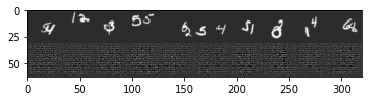

52974.4296875 3558.5224609375 3.5187647342681885


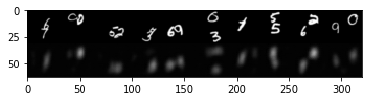

44035.40234375 4444.67578125 6.446755886077881


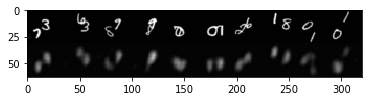

38595.05078125 5044.75390625 9.322807312011719


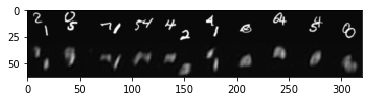

33319.1328125 5812.1533203125 12.23099946975708


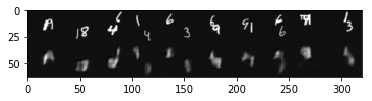

Epoch:  0 loss:  tensor(27109.9219, device='cuda:0', grad_fn=<ThAddBackward>)  time:  14.103869915008545
28681.859375 6343.31982421875 0.2811000347137451


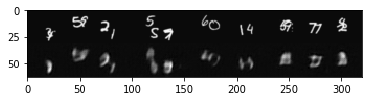

26284.8203125 6793.3017578125 3.393988847732544


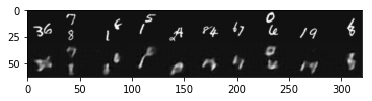

24920.890625 7193.7578125 6.289090633392334


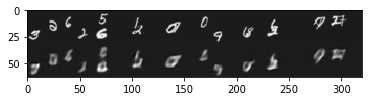

23178.626953125 7462.66357421875 9.238207340240479


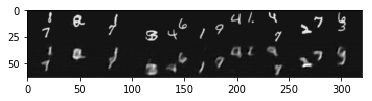

21798.30859375 7498.080078125 12.135679483413696


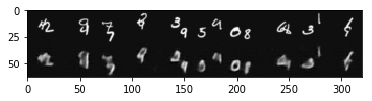

Epoch:  1 loss:  tensor(19921.8672, device='cuda:0', grad_fn=<ThAddBackward>)  time:  13.991252422332764
20839.69140625 7733.43701171875 0.3553953170776367


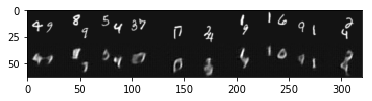

19605.7578125 7750.93212890625 3.4244794845581055


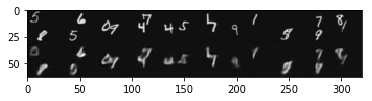

18387.341796875 7982.90625 6.533843517303467


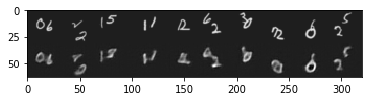

18731.888671875 8099.529296875 9.58964204788208


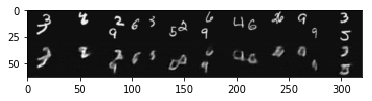

18277.42578125 8163.10400390625 12.574392557144165


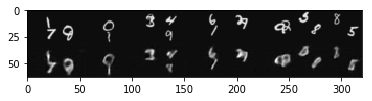

Epoch:  2 loss:  tensor(19530.1133, device='cuda:0', grad_fn=<ThAddBackward>)  time:  14.482414722442627
17528.3984375 8321.974609375 0.3804006576538086


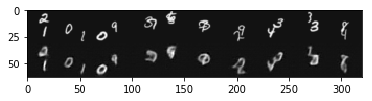

17064.5703125 8248.7021484375 3.5004658699035645


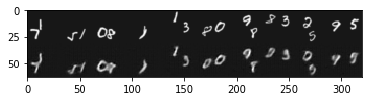

16928.626953125 8386.9736328125 6.392030239105225


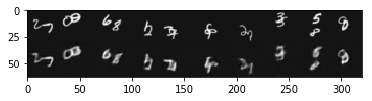

16257.07421875 8371.634765625 9.38896632194519


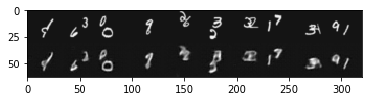

15414.568359375 8310.5322265625 12.311240196228027


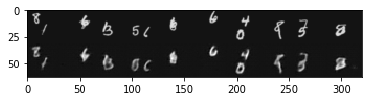

Epoch:  3 loss:  tensor(18118.4648, device='cuda:0', grad_fn=<ThAddBackward>)  time:  14.15312671661377
15839.33203125 8455.9033203125 0.4032106399536133


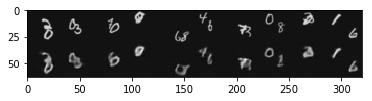

15554.0166015625 8446.2109375 3.468122959136963


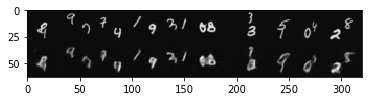

15210.4951171875 8607.177734375 6.343973636627197


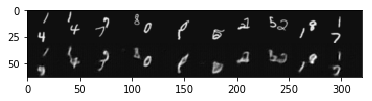

14731.783203125 8592.275390625 9.254593133926392


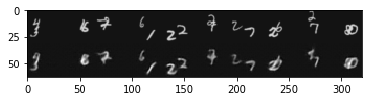

15201.435546875 8579.703125 12.094717979431152


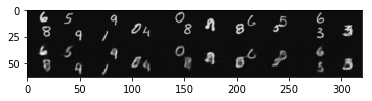

Epoch:  4 loss:  tensor(17748.6797, device='cuda:0', grad_fn=<ThAddBackward>)  time:  14.043559312820435
14696.6748046875 8663.3935546875 0.4380342960357666


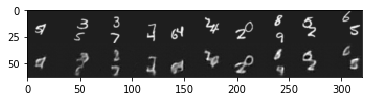

14259.3125 8551.791015625 3.5807230472564697


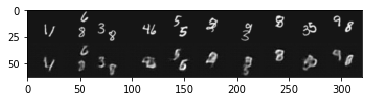

15693.45703125 8655.04296875 6.552993535995483


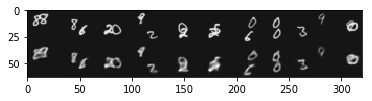

14905.91796875 8752.87890625 9.411812782287598


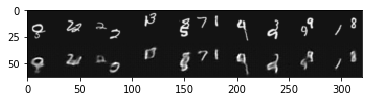

14149.3515625 8708.6650390625 12.256158351898193


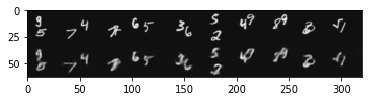

Epoch:  5 loss:  tensor(17099.2598, device='cuda:0', grad_fn=<ThAddBackward>)  time:  14.083108186721802
13794.9140625 8753.65625 0.4182267189025879


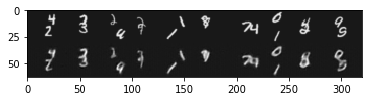

13900.50390625 8860.0224609375 3.432511806488037


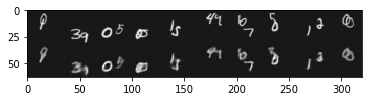

13228.728515625 8829.98046875 6.233505487442017


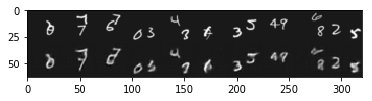

14022.7822265625 8606.697265625 9.08738923072815


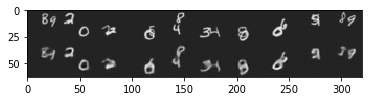

12950.5625 8728.2412109375 11.9029221534729


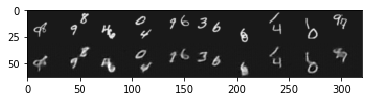

Epoch:  6 loss:  tensor(16874.6465, device='cuda:0', grad_fn=<ThAddBackward>)  time:  13.672271490097046
13200.7236328125 8753.630859375 0.4269685745239258


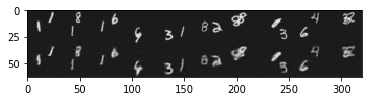

13192.7490234375 8904.0869140625 3.4080517292022705


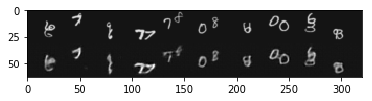

13226.908203125 8723.525390625 6.240134239196777


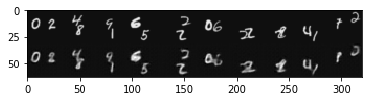

13066.599609375 8815.8017578125 9.040516138076782


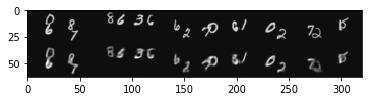

13154.501953125 8850.984375 11.864875555038452


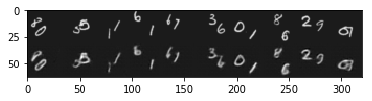

Epoch:  7 loss:  tensor(16187.4531, device='cuda:0', grad_fn=<ThAddBackward>)  time:  13.769893884658813
13097.53125 9072.3095703125 0.43112707138061523


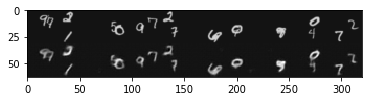

13013.060546875 8740.6962890625 3.4820237159729004


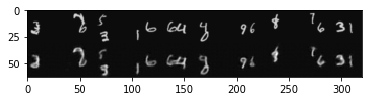

12026.515625 8836.3916015625 6.366354465484619


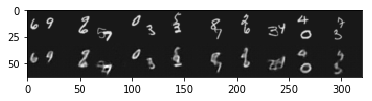

12205.3671875 8922.478515625 9.237831830978394


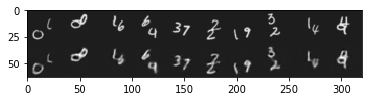

13123.35546875 8836.634765625 12.094346284866333


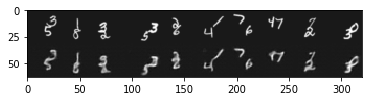

Epoch:  8 loss:  tensor(16912.9199, device='cuda:0', grad_fn=<ThAddBackward>)  time:  13.948386192321777
13056.576171875 8886.3076171875 0.3880302906036377


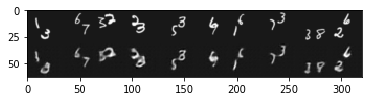

12465.220703125 8888.6708984375 3.399480104446411


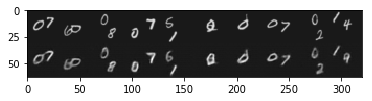

11984.87890625 8750.5458984375 6.25599217414856


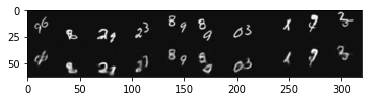

12647.333984375 8898.359375 9.115586042404175


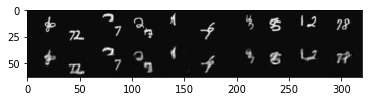

12289.580078125 8867.7119140625 11.954387426376343


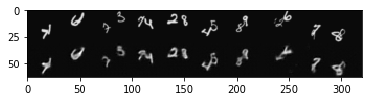

Epoch:  9 loss:  tensor(16085.4629, device='cuda:0', grad_fn=<ThAddBackward>)  time:  13.81743311882019
12191.1484375 8818.2294921875 0.38971781730651855


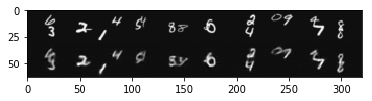

12978.1015625 8791.642578125 3.7428977489471436


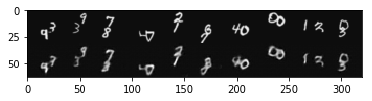

11475.861328125 8891.640625 6.99936318397522


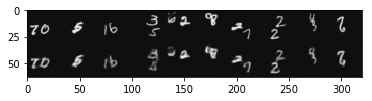

12089.064453125 8985.111328125 10.087281465530396


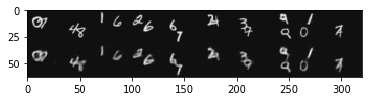

12148.927734375 8890.900390625 12.928157091140747


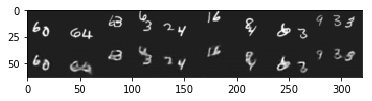

Epoch:  10 loss:  tensor(16136.7373, device='cuda:0', grad_fn=<ThAddBackward>)  time:  14.775591373443604
12061.998046875 9051.34765625 0.3796083927154541


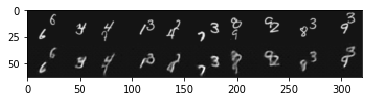

11681.0166015625 8977.9033203125 3.364819049835205


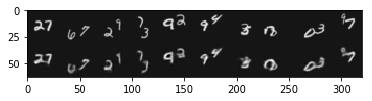

11623.576171875 8855.6708984375 6.241930246353149


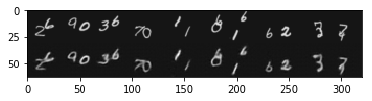

11429.392578125 9050.365234375 9.056713819503784


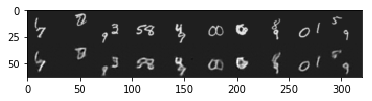

11844.9482421875 8913.4541015625 11.87731385231018


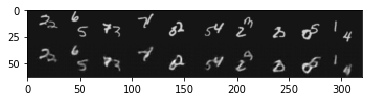

Epoch:  11 loss:  tensor(15641.6768, device='cuda:0', grad_fn=<ThAddBackward>)  time:  13.662205696105957
10679.63671875 8981.673828125 0.368441104888916


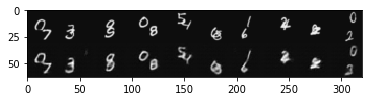

11352.767578125 9042.10546875 3.3309693336486816


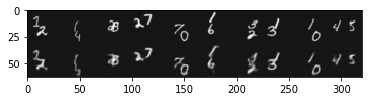

11798.91796875 8931.775390625 6.087282180786133


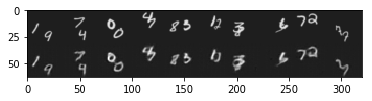

11690.5146484375 8960.9775390625 8.831793308258057


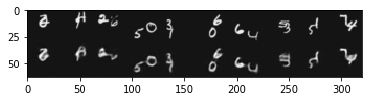

11642.7939453125 8983.48828125 11.570559978485107


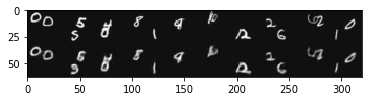

Epoch:  12 loss:  tensor(15356.5928, device='cuda:0', grad_fn=<ThAddBackward>)  time:  13.502302885055542
10789.6171875 8907.59765625 0.43079233169555664


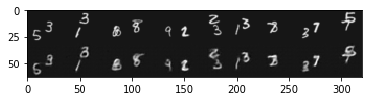

11720.8671875 8910.49609375 3.549607992172241


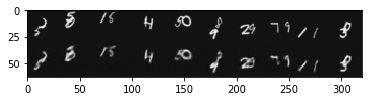

11606.4921875 8861.546875 6.430171966552734


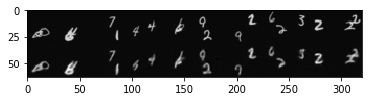

11159.9482421875 8963.9755859375 9.337788820266724


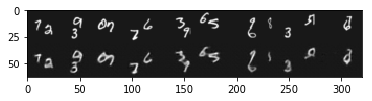

10751.904296875 9146.6318359375 12.455078601837158


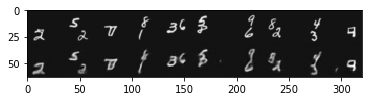

Epoch:  13 loss:  tensor(15518.0381, device='cuda:0', grad_fn=<ThAddBackward>)  time:  14.327450275421143
11619.513671875 9007.810546875 0.4813675880432129


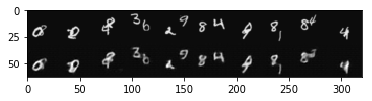

11395.0302734375 9043.0478515625 3.527587652206421


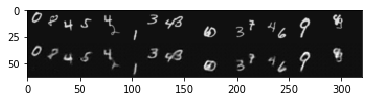

10655.9453125 9061.400390625 6.435683012008667


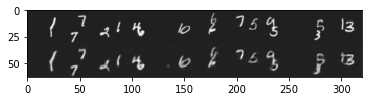

10627.6416015625 9108.1171875 9.378445863723755


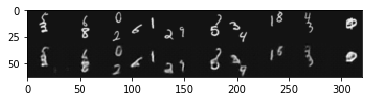

10854.2734375 8976.7265625 12.272884845733643


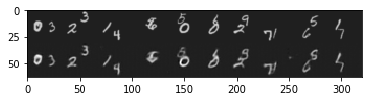

Epoch:  14 loss:  tensor(14995.4072, device='cuda:0', grad_fn=<ThAddBackward>)  time:  14.123314619064331
11955.001953125 8767.927734375 0.4516613483428955


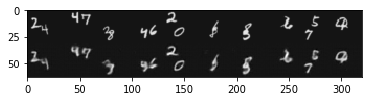

10996.3330078125 8923.181640625 3.5419259071350098


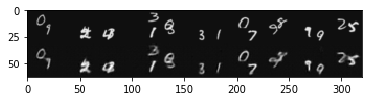

10434.1611328125 8979.357421875 6.409161567687988


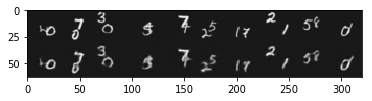

11543.02734375 9039.974609375 9.324822187423706


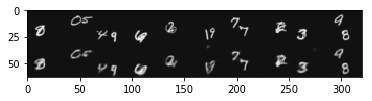

11465.580078125 9056.3095703125 12.307817935943604


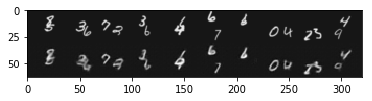

Epoch:  15 loss:  tensor(15090.0625, device='cuda:0', grad_fn=<ThAddBackward>)  time:  14.203214406967163
11233.8115234375 8991.126953125 0.44211864471435547


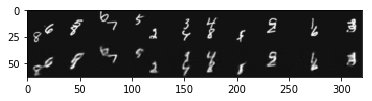

11075.58203125 8815.5 3.582552433013916


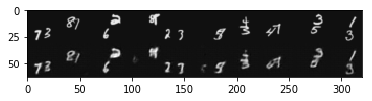

10511.2001953125 8963.7880859375 6.506124258041382


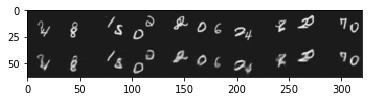

10318.943359375 8903.421875 9.417123794555664


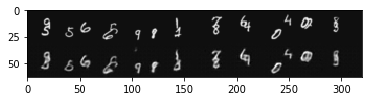

10572.140625 9022.4990234375 12.292783260345459


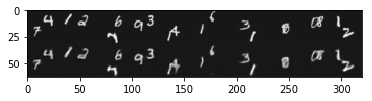

Epoch:  16 loss:  tensor(15403.9033, device='cuda:0', grad_fn=<ThAddBackward>)  time:  14.168655157089233
10037.51953125 8970.4482421875 0.4076113700866699


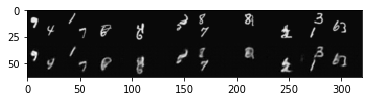

10975.669921875 8889.759765625 3.4474453926086426


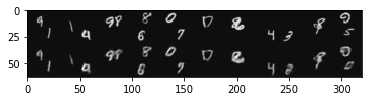

10515.7705078125 8995.1728515625 6.302123785018921


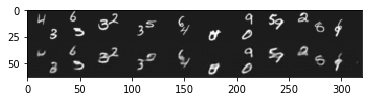

11183.5625 8838.9033203125 9.215461492538452


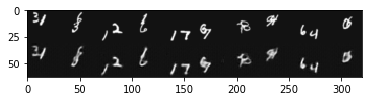

10830.14453125 9036.9267578125 12.079119443893433


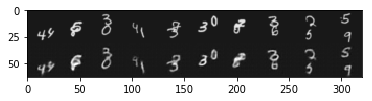

Epoch:  17 loss:  tensor(15013.9844, device='cuda:0', grad_fn=<ThAddBackward>)  time:  13.922573804855347
10357.59375 8924.68359375 0.4285469055175781


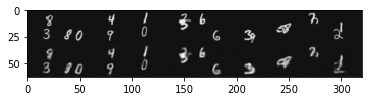

10694.677734375 8985.515625 3.5826313495635986


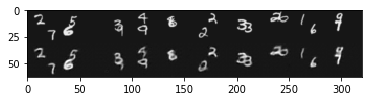

10949.30078125 8985.6591796875 6.41476035118103


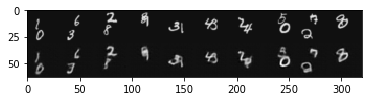

10774.765625 9014.646484375 9.268690824508667


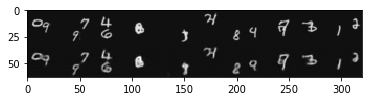

11117.6015625 9111.3623046875 12.071709632873535


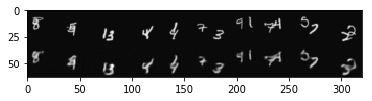

Epoch:  18 loss:  tensor(14327.4268, device='cuda:0', grad_fn=<ThAddBackward>)  time:  13.876577377319336
10172.40234375 9010.873046875 0.4024224281311035


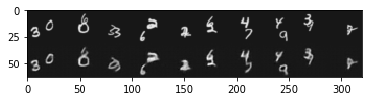

10322.962890625 9024.673828125 3.4219369888305664


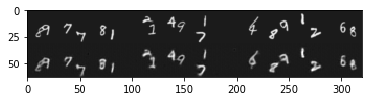

10165.73046875 9090.7158203125 6.240694761276245


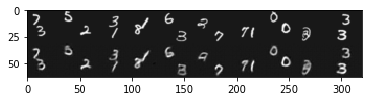

10552.99609375 8935.0732421875 9.06386923789978


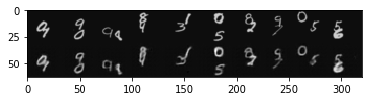

10440.669921875 8994.3173828125 11.924875259399414


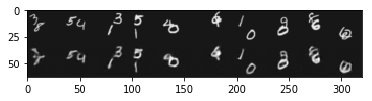

Epoch:  19 loss:  tensor(14319.1367, device='cuda:0', grad_fn=<ThAddBackward>)  time:  13.718190670013428


NameError: name 'l_gan_losses' is not defined

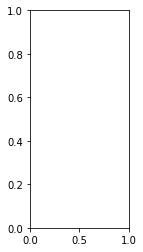

In [9]:
lr = 0.001

encoder_optimizer = optim.Adam(encoder.parameters(), lr=lr)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr)


l2_losses = []
kl_divergence = []
losses = []

gamma = 1
for epoch in range(20):
    start = time.time()
        
    for i, data in enumerate(train_loader):

        # Zero grad all the optimizers
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        # Load Data
        data = data.to(device)
        
        # VAE
        mu, logvar = encoder(data)
        encoding = encoder.rsample(mu, logvar)
        
        # VAE output
        image_q_z = decoder(encoding)
        
        # KL divergence between mu, logvar sampled from p(z|x)
        kl = loss_function_kld(mu, logvar)
        
        # reconstruction loss
        l2_loss = loss_function_mse(image_q_z, data)
        
        # compute final loss and backprop
        loss = kl + l2_loss;
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        
        
        if i%100 == 0:
            
            l2_losses.append(l2_loss)
            kl_divergence.append(kl)
            losses.append(loss)

            print(l2_loss.item(), kl.item(), time.time() - start)
            
            x_vis = np.concatenate(data[:,0,:,:][0:10].detach().cpu().numpy(), axis=1)
            g_vis = np.concatenate(image_q_z[:,0,:,:][0:10].detach().cpu().numpy(), axis=1)
            plt.imshow(np.concatenate( (x_vis, g_vis), axis=0), cmap='gray')
            plt.show()
            
    print("Epoch: ", epoch, "loss: ", loss, " time: ", time.time() - start)
    if epoch % 10 == 0:
        torch.save({'epoch':epoch,'enc_state_dict': encoder.state_dict(), \
                  'dec_state_dict': decoder.state_dict(),\
                  'loss': losses},\
                 'checkpoints/vae_e' + str(epoch)+ '.ckpt'
                )


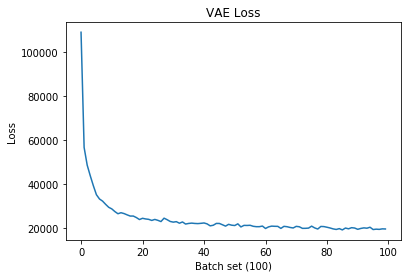

In [10]:
#Losses:
plt.figure()

plt.plot(losses)
plt.title("VAE Loss")
plt.xlabel("Batch set (100)")
plt.ylabel("Loss")


plt.show()

LSTM

In [11]:
class Predictor(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(Predictor, self).__init__()              
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1)

    def forward(self, x):
        x, _ = self.lstm(x)
        return x

In [12]:
class MovingMNIST_seq(Dataset):
    def __init__(self, dataset , transform = None ):
        self.data = dataset.f.arr_0.transpose(0,3,2,1)
        num_seq = int(self.data.shape[0] / 30 )
        self.data = self.data.reshape((num_seq, 30, 64, 64, 1 ) )
        self.transform = transform
    
    def __getitem__(self, index):
        images = self.data[index]
        trans_images = []
        for i in images:
            if self.transform is not None:
                trans_image = self.transform(i)
                trans_images.append(trans_image)
        b = torch.Tensor(30, 1, 32, 32)
        return torch.cat(trans_images, out=b)

    def __len__(self): 
        return len(self.data)
    

In [13]:
train_data = np.load('train_data.npz')
train_dataset = MovingMNIST_seq(train_data, 
                            transform=transforms.Compose([
                                transforms.ToPILImage(), 
                                transforms.Resize(32),
                                transforms.ToTensor(),
                                transforms.Normalize((0.04905,), (0.1992,))]))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8)

test_data = np.load('test_data.npz')
test_dataset = MovingMNIST_seq(test_data, 
                            transform=transforms.Compose([
                                transforms.ToPILImage(), 
                                transforms.Resize(32),
                                transforms.ToTensor(),
                                transforms.Normalize((0.04905,), (0.1992,))]))

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=8)

Epoch  0
24502.828125 0.4826996326446533


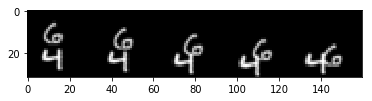

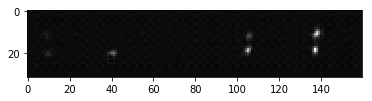

21027.193359375 3.049938201904297


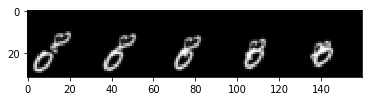

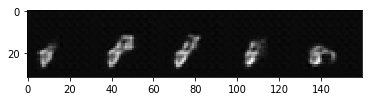

20097.220703125 5.633671283721924


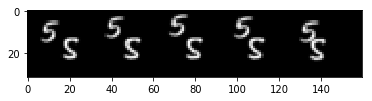

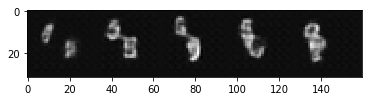

19368.337890625 8.393678903579712


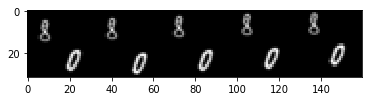

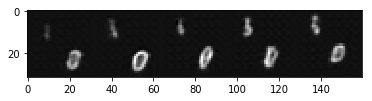

20234.404296875 11.097673416137695


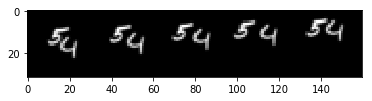

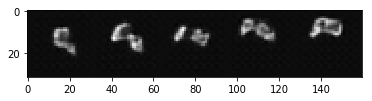

Epoch  1
18610.65234375 0.5663712024688721


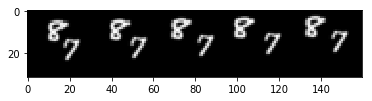

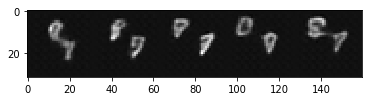

19253.404296875 3.45172381401062


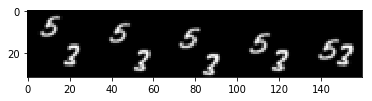

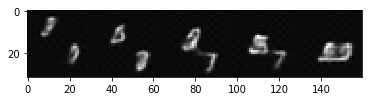

18391.79296875 6.251676321029663


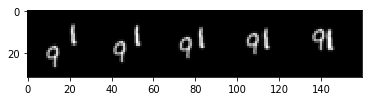

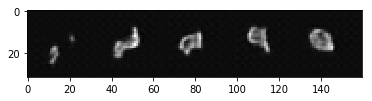

18916.951171875 8.935673952102661


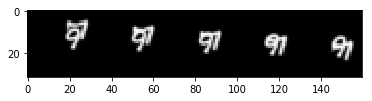

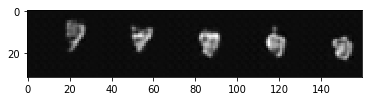

18500.12109375 11.56368374824524


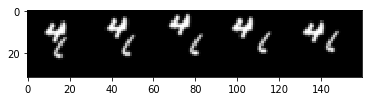

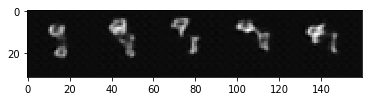

Epoch  2
17827.5234375 0.5874030590057373


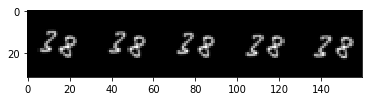

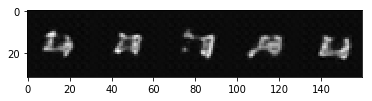

18402.080078125 3.471357583999634


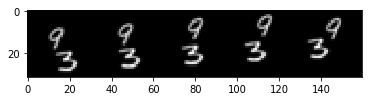

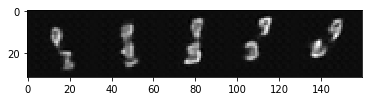

17835.564453125 6.0673558712005615


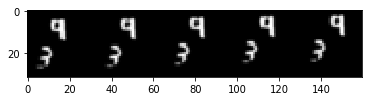

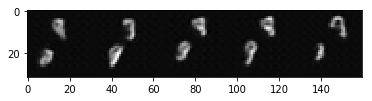

17508.984375 8.911346673965454


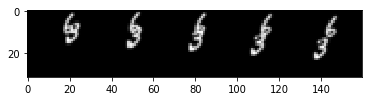

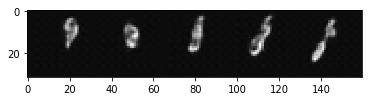

17953.85546875 11.5913724899292


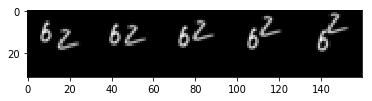

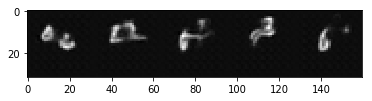

Epoch  3
16767.712890625 0.626230001449585


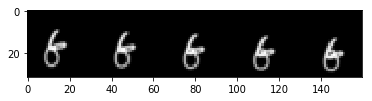

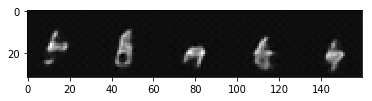

17847.244140625 3.430832624435425


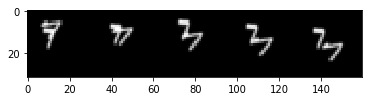

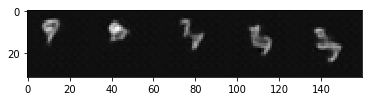

16958.544921875 6.186980485916138


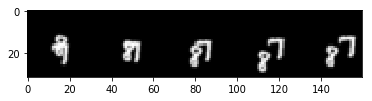

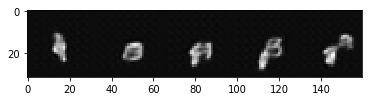

16879.462890625 8.91879653930664


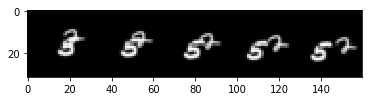

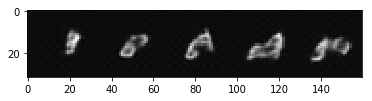

16776.91796875 11.614797353744507


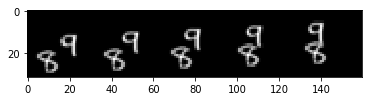

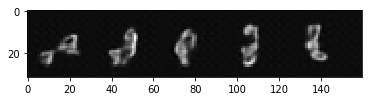

Epoch  4
16659.697265625 0.6359257698059082


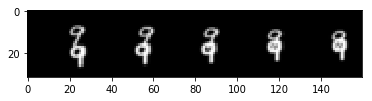

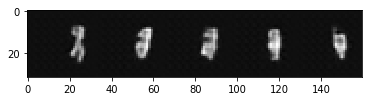

16626.79296875 3.5159265995025635


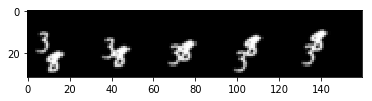

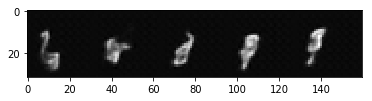

16601.134765625 6.215951442718506


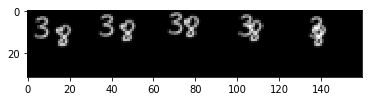

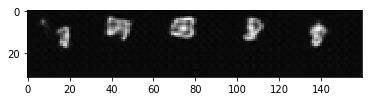

16358.7978515625 8.959957599639893


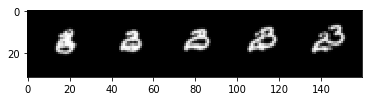

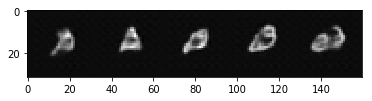

15803.7060546875 11.635929107666016


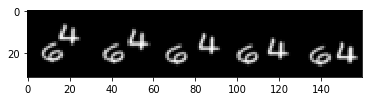

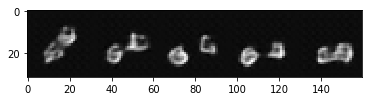

Epoch  5
15973.4638671875 0.5544910430908203


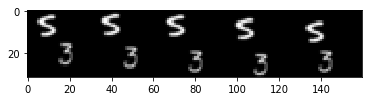

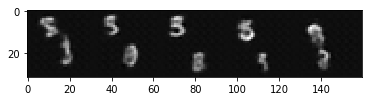

16597.705078125 3.5518417358398438


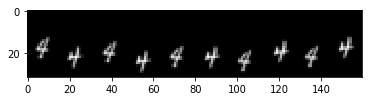

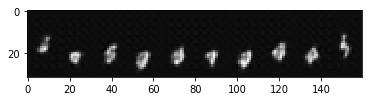

16015.5693359375 6.199862003326416


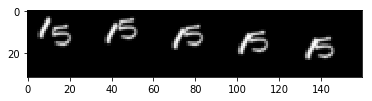

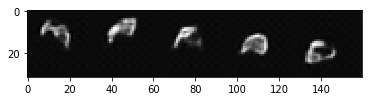

15450.4775390625 8.912536859512329


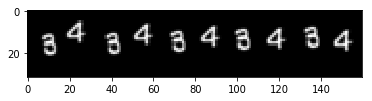

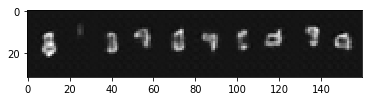

15245.1142578125 11.555887937545776


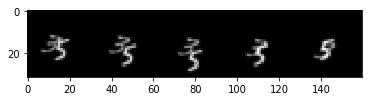

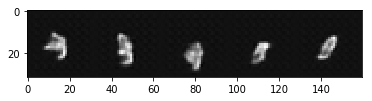

Epoch  6
15857.6962890625 0.5694754123687744


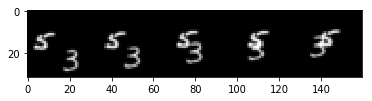

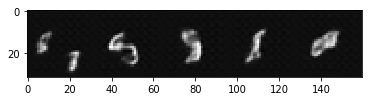

15512.8349609375 3.5014662742614746


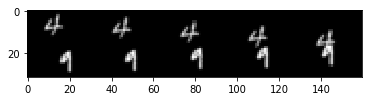

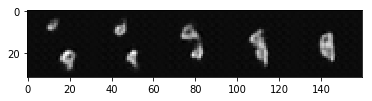

14698.1103515625 6.157449722290039


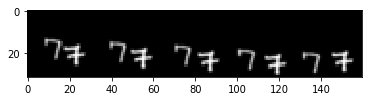

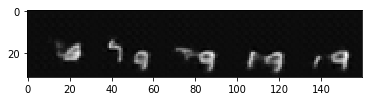

14159.021484375 8.933442831039429


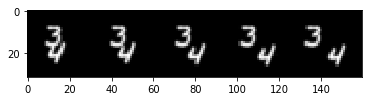

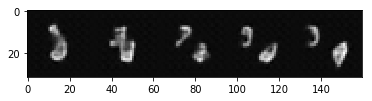

14949.4326171875 11.633479595184326


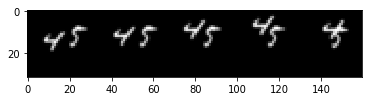

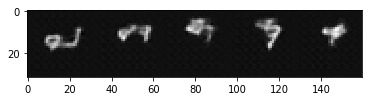

Epoch  7
14065.2158203125 0.6073117256164551


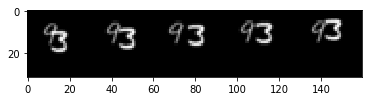

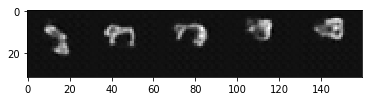

14248.7041015625 3.499312400817871


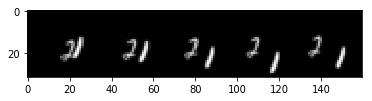

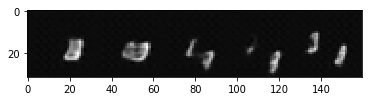

14175.55078125 6.211306571960449


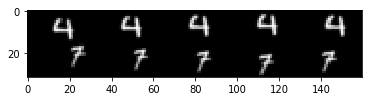

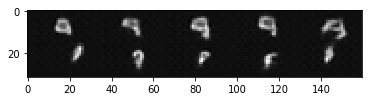

15370.708984375 8.868545770645142


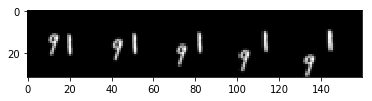

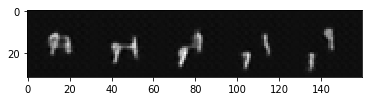

14149.61328125 11.596229076385498


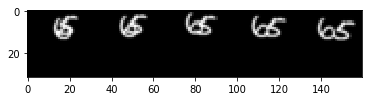

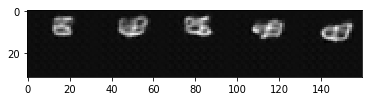

Epoch  8
14249.76171875 0.5830411911010742


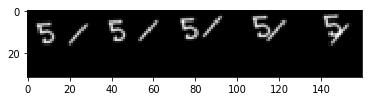

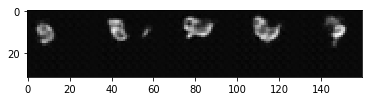

14609.4921875 3.5194852352142334


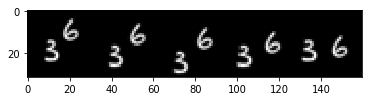

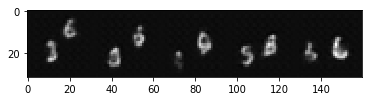

13921.54296875 6.226112604141235


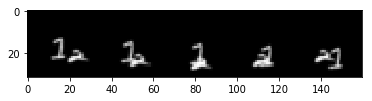

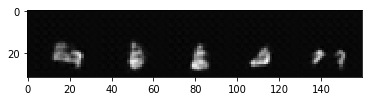

14468.908203125 8.978103399276733


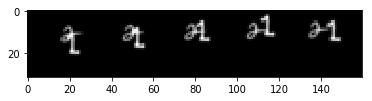

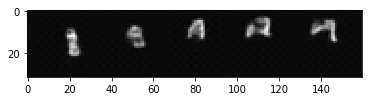

13686.6357421875 11.662113904953003


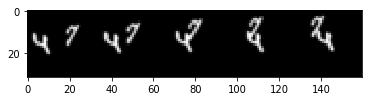

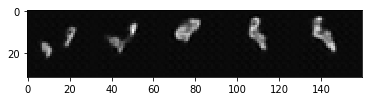

Epoch  9
13569.57421875 0.5716276168823242


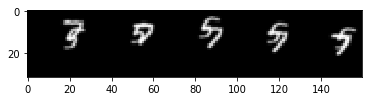

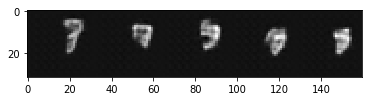

13395.9208984375 3.5996201038360596


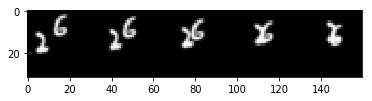

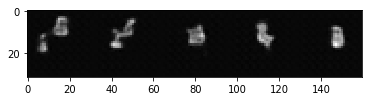

13169.8779296875 6.271615028381348


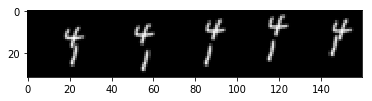

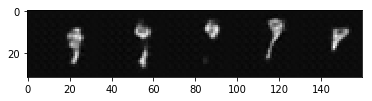

13201.78125 8.963616847991943


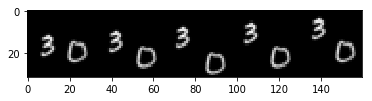

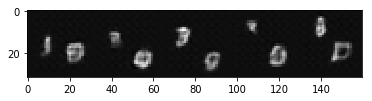

12955.482421875 11.695614576339722


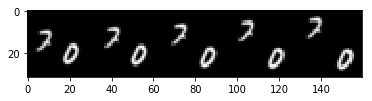

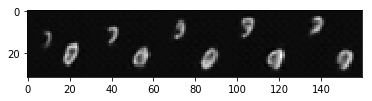

Epoch  10
13007.8955078125 0.7371246814727783


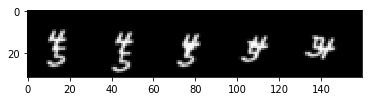

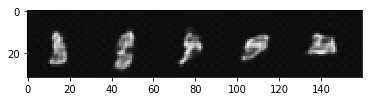

12542.025390625 3.5771074295043945


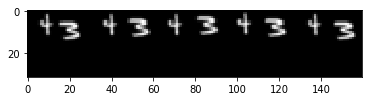

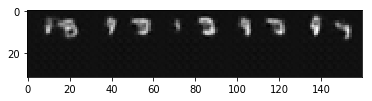

12785.4716796875 6.253107309341431


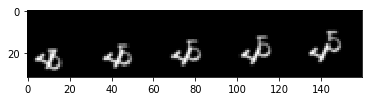

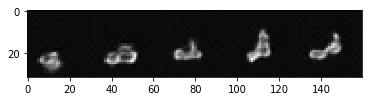

12714.43359375 9.073114156723022


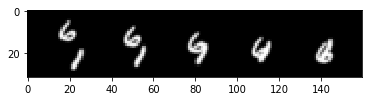

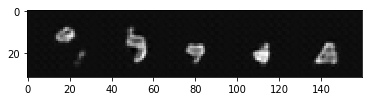

12720.724609375 11.753106594085693


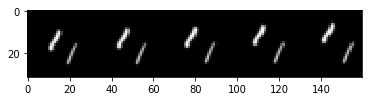

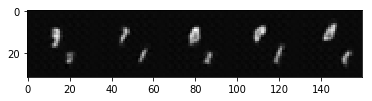

Epoch  11
12239.93359375 0.5742940902709961


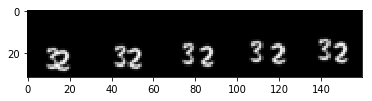

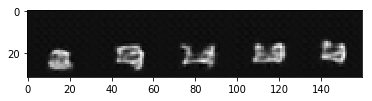

11866.3828125 3.541372060775757


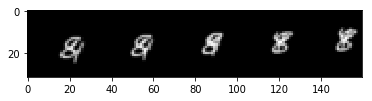

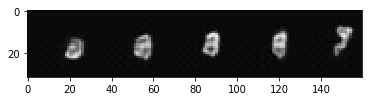

12608.63671875 6.25610613822937


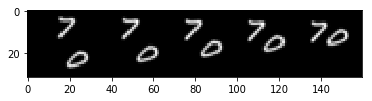

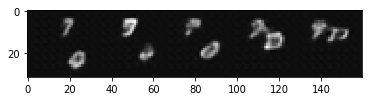

11783.322265625 9.03428030014038


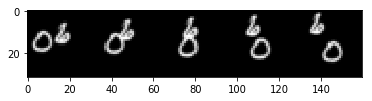

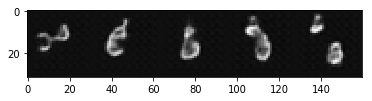

11969.4677734375 11.8262779712677


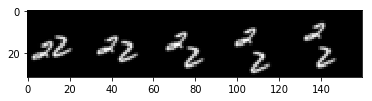

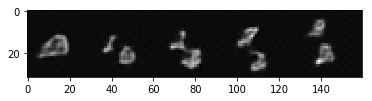

Epoch  12
11218.7880859375 0.6107497215270996


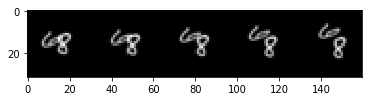

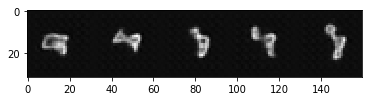

11585.5712890625 3.51741361618042


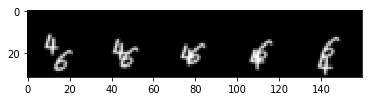

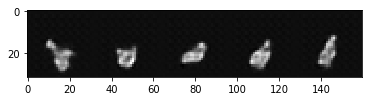

11626.6103515625 6.253408908843994


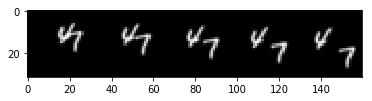

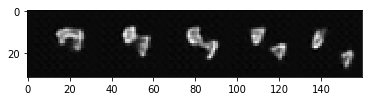

11923.7763671875 8.953442335128784


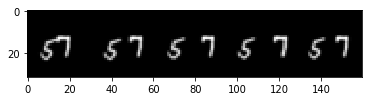

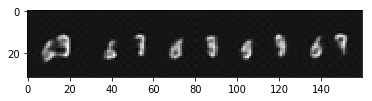

11321.728515625 11.673413276672363


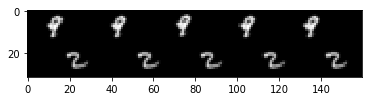

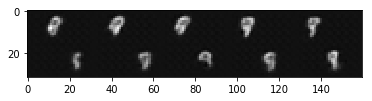

Epoch  13
11643.8681640625 0.6892001628875732


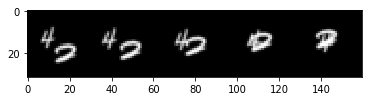

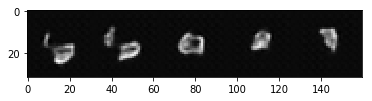

11389.3583984375 3.565220355987549


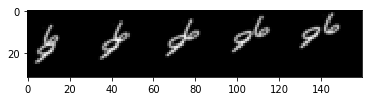

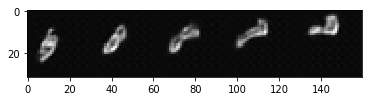

11176.3291015625 6.261191129684448


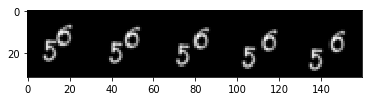

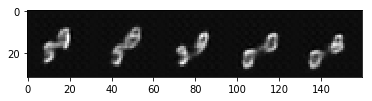

11287.2177734375 9.065192699432373


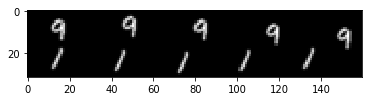

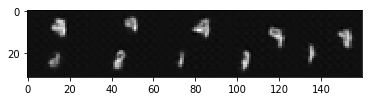

11482.400390625 11.734306573867798


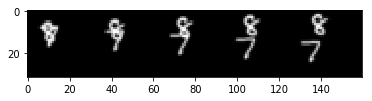

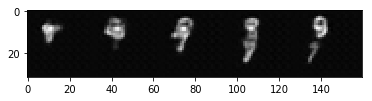

Epoch  14
10446.892578125 0.464158296585083


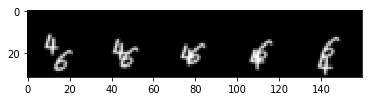

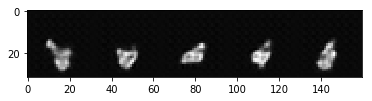

11353.76171875 3.4468295574188232


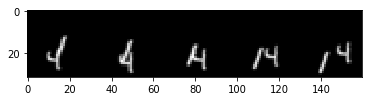

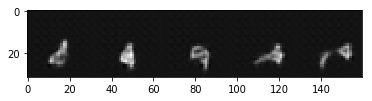

10540.435546875 6.206850051879883


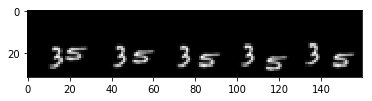

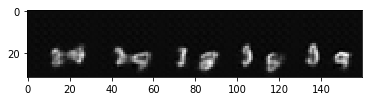

11145.765625 8.909284830093384


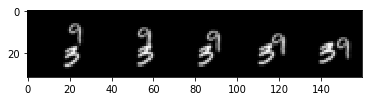

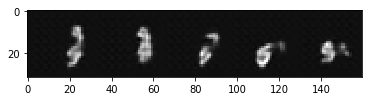

10594.6513671875 11.582829236984253


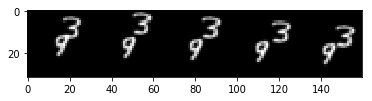

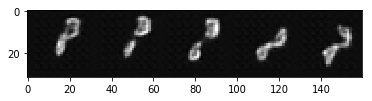

Epoch  15
11207.3505859375 0.5362939834594727


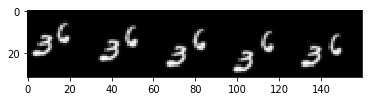

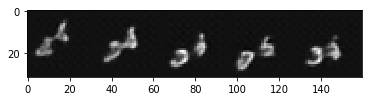

10256.31640625 3.4302098751068115


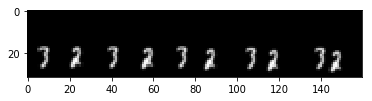

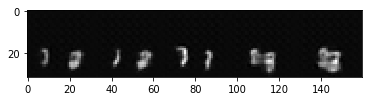

10625.4833984375 6.127475261688232


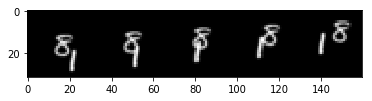

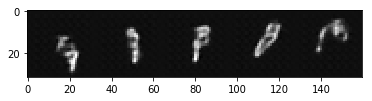

10030.3203125 8.923470735549927


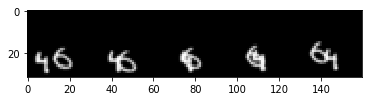

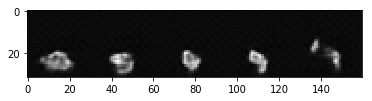

10447.9853515625 11.615478992462158


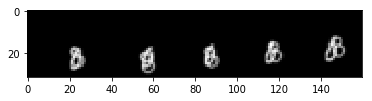

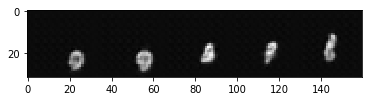

Epoch  16
10580.59765625 0.623704195022583


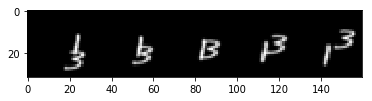

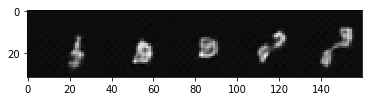

10173.462890625 3.5147132873535156


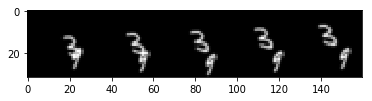

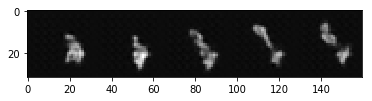

9681.46484375 6.186715126037598


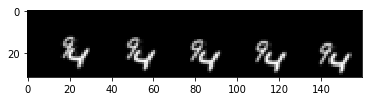

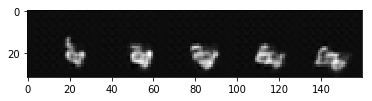

9695.6875 8.834720611572266


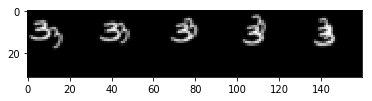

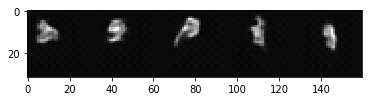

9394.3857421875 11.590715646743774


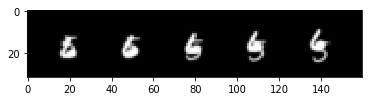

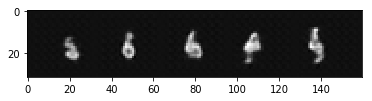

Epoch  17
9442.75 0.7572636604309082


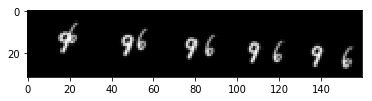

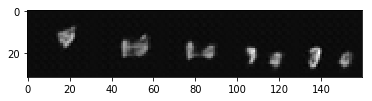

9792.95703125 3.5972557067871094


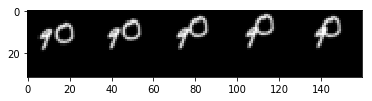

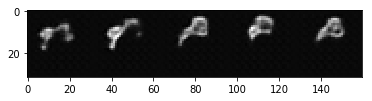

9270.646484375 6.317275762557983


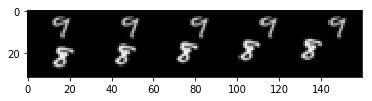

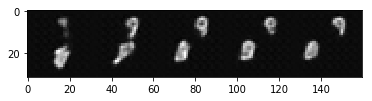

9567.7744140625 8.931303977966309


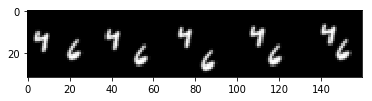

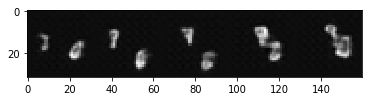

9164.392578125 11.617266654968262


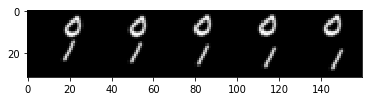

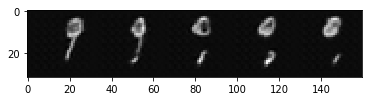

Epoch  18
9206.7177734375 0.5573270320892334


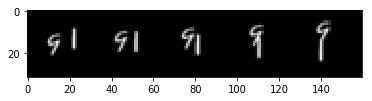

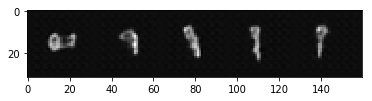

9482.173828125 3.519697904586792


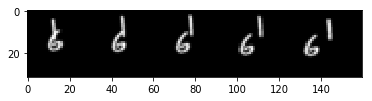

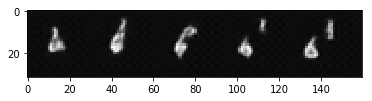

9362.896484375 6.223686933517456


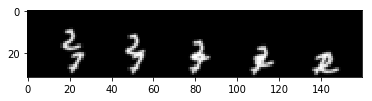

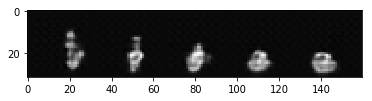

9042.1640625 8.931686878204346


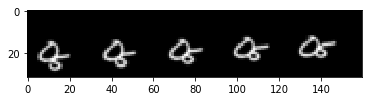

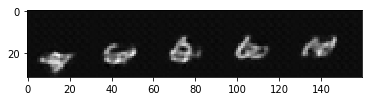

9085.4814453125 11.631675958633423


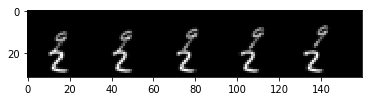

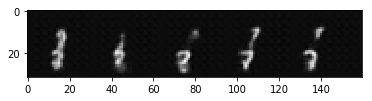

Epoch  19
8670.650390625 0.5453193187713623


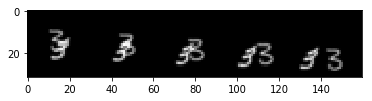

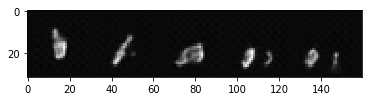

9068.7412109375 3.537841558456421


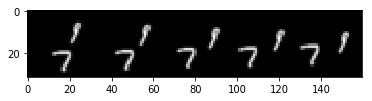

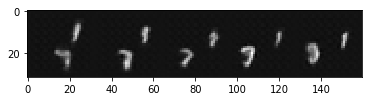

8532.173828125 6.14187479019165


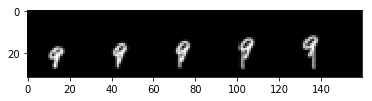

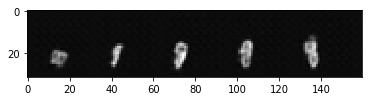

8761.8974609375 8.921968221664429


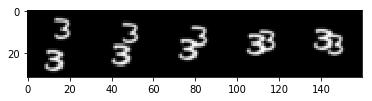

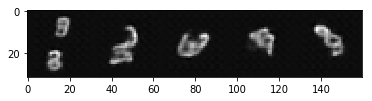

8494.8388671875 11.581851482391357


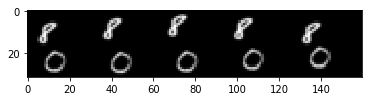

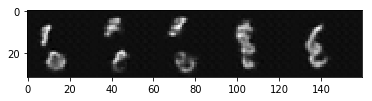

In [14]:
checkpoint = torch.load('checkpoints/vae_e20.ckpt')
encoder.load_state_dict(checkpoint['enc_state_dict'])
decoder.load_state_dict(checkpoint['dec_state_dict'])

encoder.eval() #comment for joint training
decoder.eval()

predictor = Predictor(100, 100, 1).to(device)
predictor_optimizer = optim.Adam(predictor.parameters()) #, lr=0.01) #uncomment for joint training

encoder_optimizer = optim.Adam(encoder.parameters())#, lr=0.000001) #uncomment for joint training
decoder_optimizer = optim.Adam(decoder.parameters())#, lr=0.00001) #uncomment for joint training

losses = []
per_pixel_error = []

epochs = 20
for epoch in range(epochs):
    print('Epoch ', epoch)
    start = time.time()
    for i, data in enumerate(train_loader):
        # move data to device
        data = data.to(device)

        # get batch size and frames given by loader
        mini_batch = data.shape[0]
        frames_per_seq = data.shape[1]

        # display some frames from sequence
        frame = np.concatenate(data[0, 0:5, :, :].view(-1, 32, 32).detach().cpu().numpy(), axis=1 )
        real_frames = data

        # encode the frames
        data = data.reshape(mini_batch*frames_per_seq, 1, 32, 32)
        mu, logvar = encoder(data)
        encoded = encoder.rsample(mu, logvar)
        encoded = encoded.reshape(mini_batch, frames_per_seq, -1)
        encoded = encoded.transpose(1,0)

        # pass the frames through the prediction network
        output_preds = predictor(encoded)
        
        # compute the loss and backprop
        predictor_optimizer.zero_grad()
        # encoder_optimizer.zero_grad() #uncomment for joint training
        
        loss = F.mse_loss(output_preds[0:-1], encoded[1:])
        loss.backward()
        predictor_optimizer.step()
        # encoder_optimizer.step() #uncomment for joint training

        if i % 50 == 0:
            losses.append(loss.item())
            
            print(loss.item(), time.time() - start)
            
            # display the real frames
            plt.imshow(frame, cmap='gray')
            plt.show()
            
            # display the predicted frames
            output_preds = output_preds.transpose(1,0)
            output_preds = output_preds.reshape(mini_batch*frames_per_seq, 100, 1, 1)
            
            # decode the predictions to find per pixel error and to display some
            decoded = decoder(output_preds)
            decoded = decoded.reshape(mini_batch, frames_per_seq, 32, 32)

            frame_preds = np.concatenate(decoded[0, 0:5, :, :].view(-1, 32, 32).detach().cpu().numpy(), axis=1 )
            plt.imshow(frame_preds, cmap='gray')
            plt.show()
            
            # compute per pixel loss, normalized
            ppe = torch.sum(real_frames - decoded) / (mini_batch * 32*32*30)
            per_pixel_error.append(ppe)
        
        
            
    
    

These losses plots are for case of separate encoder and lstm training.

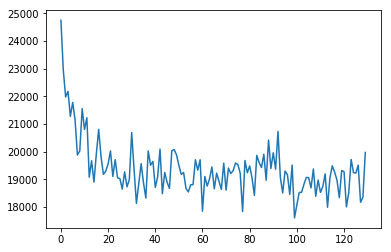

In [22]:
plt.plot(losses)

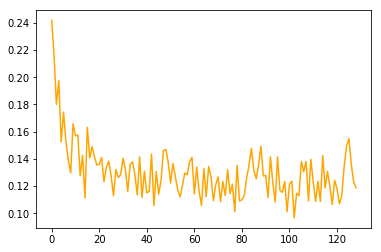

In [21]:
plt.plot(per_pixel_error, color='orange')

In [15]:
torch.save({'epoch':epoch,'pred_state_dict': predictor.state_dict(), \
                  'loss': losses, 'ppe': per_pixel_error},\
                 'checkpoints/lstm_joint_e' + str(epoch)+ '.ckpt'
                )